In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# All imports are defined here:-

In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import random
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Defining Training Directories and CSV's:-

In [ ]:
train_dir=r"/content/drive/MyDrive/A_deep_learning_lab/ATDL_Assignment02/archive/sign_data/sign_data/train"
train_csv=r"/content/drive/MyDrive/A_deep_learning_lab/ATDL_Assignment02/archive/sign_data/sign_data/train_data.csv"
test_csv=r"/content/drive/MyDrive/A_deep_learning_lab/ATDL_Assignment02/archive/sign_data/sign_data/test_data.csv"
test_dir=r"/content/drive/MyDrive/A_deep_learning_lab/ATDL_Assignment02/archive/sign_data/sign_data/test"

In [ ]:
df_train=pd.read_csv(train_csv)
df_train.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
22912,066/06_066.png,066/03_066.png,0
21568,035/06_035.png,035_forg/01_0103035.PNG,1
2429,004/004_23.PNG,004_forg/0105004_03.png,1
21957,037/12_037.png,037_forg/02_0114037.PNG,1
18091,028/05_028.png,028/01_028.png,0
8751,001/001_08.PNG,001/001_02.PNG,0
9814,006/006_22.PNG,006/006_06.PNG,0
22617,061/04_061.png,061/10_061.png,0
15592,057/12_057.png,057/03_057.png,0
17756,013/01_013.png,013/07_013.png,0


from matplotlib import pyplot as plt
_df_0['1'].plot(kind='hist', bins=20, title='1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['1'].plot(kind='line', figsize=(8, 4), title='1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_2['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['1'].plot(kind='hist', bins=20, title='1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['1'].plot(kind='line', figsize=(8, 4), title='1')
plt.gca().spines[['top', 'right']].set_visible(False)

# Here we are seeing that 1 denotes for forged pair and 0 denotes for geniune pair of signatures..

In [ ]:
df_test=pd.read_csv(test_csv)
df_test.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
2104,049/09_049.png,049_forg/02_0206049.PNG,1
2908,069/12_069.png,069/07_069.png,0
1717,050/08_050.png,050/06_050.png,0
5274,061/12_061.png,061_forg/01_0112061.PNG,1
40,068/04_068.png,068_forg/01_0124068.PNG,1
4085,054/05_054.png,054/04_054.png,0
1469,051/06_051.png,051/05_051.png,0
1145,067/08_067.png,067_forg/01_0205067.PNG,1
5269,061/12_061.png,061_forg/02_0112061.PNG,1
1551,050/12_050.png,050_forg/04_0125050.PNG,1


In [ ]:
df_train.shape

(23205, 3)

In [ ]:
df_test.shape

(5747, 3)

# Making Custom Pytorch Siamese Dataset:-

the ____len____ function which returns the size of the dataset, and

the ____getitem____ function which returns a sample from the dataset given an index.

In [ ]:
df_train[4:5]

,068/09_068.png,068_forg/03_0113068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [ ]:
image1_path=os.path.join(train_dir,df_train.iat[4,0])
image1_path

'/content/drive/MyDrive/A_deep_learning_lab/ATDL_Assignment02/archive/sign_data/sign_data/train/068/09_068.png'

In [ ]:
class Dataset(Dataset):
    #default constuctor for assigning values
    def __init__(self,train_dir=None,train_csv=None,transform=None):
        self.train_dir=train_dir
        self.train_data=pd.read_csv(train_csv)
        self.train_data.columns=['image1','image2','class']
        self.transform=transform

    def __getitem__(self,idx): ## __getitem__ returns a sample data given index, idx=index

        img1_path=os.path.join(self.train_dir,self.train_data.iat[idx,0])
        img2_path=os.path.join(self.train_dir,self.train_data.iat[idx,1])

        img1=Image.open(img1_path)
        img2=Image.open(img2_path)

        img1=img1.convert('L') #L mode image, that means it is a single channel image - normally interpreted as greyscale.
        img2=img2.convert('L')

        img1=self.transform(img1)
        img2=self.transform(img2)

        return img1, img2, torch.from_numpy(np.array([int(self.train_data.iat[idx,2])],dtype=np.float32))


    def __len__(self): ## __len__ returns the size of the dataset..
        return len(self.train_data)

# Returns Image1, Image2 and the class label(whether 0 or 1).

In [ ]:
dataset = Dataset(train_dir,train_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

In [ ]:
dataset

# Siamese Network:-

In [ ]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()


        self.conv1=nn.Conv2d(1,50,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
         # L1 ImgIn shape=(?, 28, 28, 1)      # (n-f+2*p/s)+1
        #    Conv     -> (?, 24, 24, 50)
        #    Pool     -> (?, 12, 12, 50)


        self.conv2 = nn.Conv2d(50,60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # L2 ImgIn shape=(?, 12, 12, 50)
        #    Conv      ->(?, 8, 8, 60)
        #    Pool      ->(?, 4, 4, 60)


        self.conv3 = nn.Conv2d(60, 80,  kernel_size = 3)
        # L3 ImgIn shape=(?, 4, 4, 60)
        #    Conv      ->(?, 2, 2, 80)



        self.batch_norm1 = nn.BatchNorm2d(50)
        self.batch_norm2 = nn.BatchNorm2d(60)

#         self.dropout1 = nn.Dropout2d()

        # L4 FC 2*2*80 inputs -> 250 outputs
        self.fc1 = nn.Linear(32000, 128)
        self.fc2 = nn.Linear(128, 2)




    def forward1(self,x):
        x=self.conv1(x)
        x = self.batch_norm1(x)
        x=F.relu(x)
        x=self.pool1(x)

        x=self.conv2(x)
        x = self.batch_norm2(x)
        x=F.relu(x)
        x=self.pool2(x)

        x=self.conv3(x)
        x=F.relu(x)
#         print(x.size())
        x = x.view(x.size()[0], -1)
#         print('Output2')
#         print(x.size()) #32000 thats why the input of fully connected layer is 32000
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward1(input1)
        # forward pass of input 2
        output2 = self.forward1(input2)

        return output1, output2


# Constrastive Loss Function:-

Contrastive loss:-
Contrastive loss is widely-used in unsupervised and self-supervised learning. Originally developed by Hadsell et al. in 2016 from Yann LeCun’s group, this loss function operates on pairs of samples instead of individual samples. It defines a binary indicator Y for each pair of samples stating whether they should be deemed similar, and a learnable distance function D_W(x_1, x_2) between a pair of samples x_1, x_2, parameterized by the weights W in the neural network.

, where m>0 is a margin. The margin defines a radius around the embedding space of a sample so that dissimilar pairs of samples only contribute to the contrastive loss function if the distance D_W is within the margin.


Intuitively, this loss function encourages the neural network to learn a embedding to place samples with the same labels close to each other, while distancing the samples with different labels in the embedding space.

In [ ]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


In [ ]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=32)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
train_dataloader

In [ ]:
if torch.cuda.is_available():
    print('Yes')

Yes


In [ ]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 3e-4)

optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99)

In [ ]:
def train():
    loss= []

    for epoch in range(1,10):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()

        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())

    return net

In [ ]:
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1
 Current loss 0.6596947908401489

Epoch 2
 Current loss 0.7534894943237305

Epoch 3
 Current loss 0.7718144059181213

Epoch 4
 Current loss 0.42722633481025696

Epoch 5
 Current loss 0.266156941652298

Epoch 6
 Current loss 0.6523705720901489

Epoch 7
 Current loss 0.6042690277099609

Epoch 8
 Current loss 0.6535517573356628

Epoch 9
 Current loss 0.6828219294548035

Model Saved Successfully


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))


<ipython-input-24-220515efcd40>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt"))


<All keys matched successfully>

In [ ]:
test_dataset = Dataset(test_dir,test_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=8,batch_size=1,shuffle=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def evaluate_model(model, test_dataloader, threshold=1.5):
    """
    Evaluate the model and compute accuracy, precision, recall, and F1-score.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            x0, x1, label = data
            x0, x1, label = x0.to(device), x1.to(device), label.to(device)

            # Forward pass
            output1, output2 = model(x0, x1)
            eucledian_distance = F.pairwise_distance(output1, output2)

            # Apply threshold to classify as Genuine (0) or Forged (1)
            prediction = (eucledian_distance > threshold).float()

            # Collect labels and predictions
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return accuracy, precision, recall, f1


In [ ]:
# Evaluate the model on the test set
evaluate_model(model, test_dataloader, threshold=1.5)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: 0.4830
Precision: 0.5385
Recall: 0.0094
F1-Score: 0.0185


(0.48303462676178877,
 0.5384615384615384,
 0.009411764705882352,
 0.01850016518004625)

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Testing the model by comparing the model's distance prediction between two pairs of Signature:-

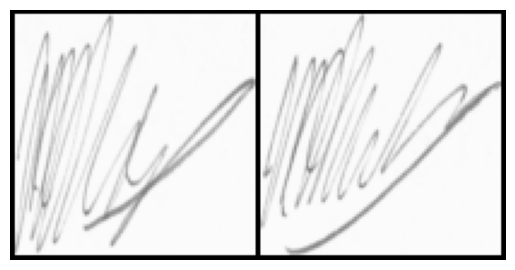

Predicted Eucledian Distance:- 0.6251428723335266
Actual Label:- Original Pair Of Signature


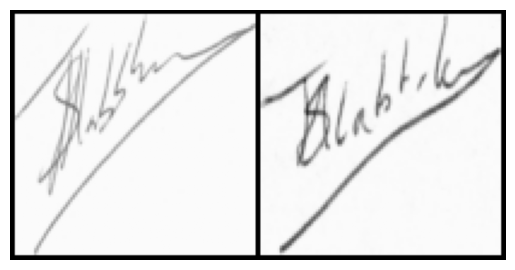

Predicted Eucledian Distance:- 0.6925491094589233
Actual Label:- Forged Pair Of Signature


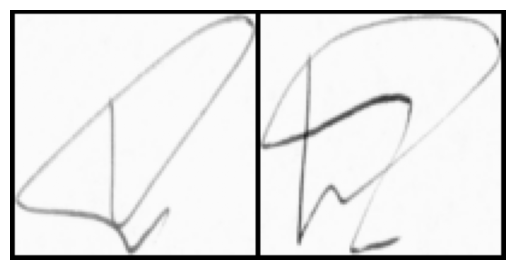

Predicted Eucledian Distance:- 1.179945468902588
Actual Label:- Forged Pair Of Signature


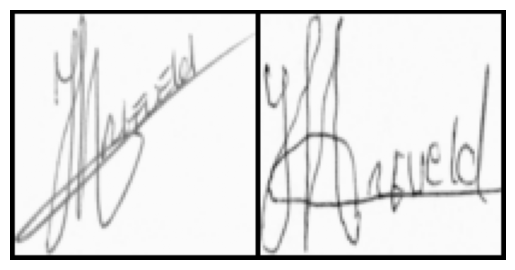

Predicted Eucledian Distance:- 0.7837536931037903
Actual Label:- Forged Pair Of Signature


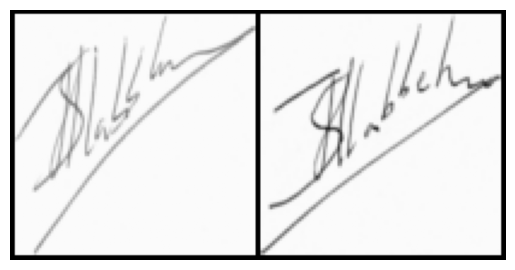

Predicted Eucledian Distance:- 0.634527862071991
Actual Label:- Forged Pair Of Signature


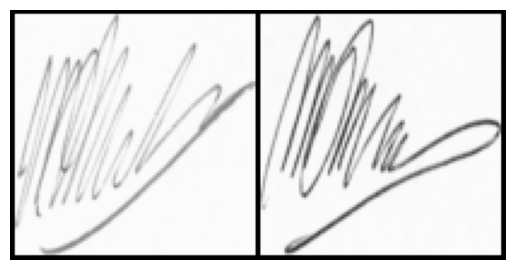

Predicted Eucledian Distance:- 1.0506781339645386
Actual Label:- Forged Pair Of Signature


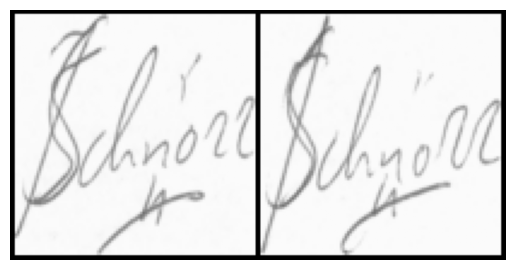

Predicted Eucledian Distance:- 0.7004218697547913
Actual Label:- Original Pair Of Signature


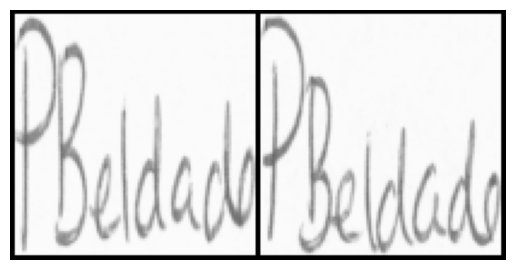

Predicted Eucledian Distance:- 0.85331791639328
Actual Label:- Original Pair Of Signature


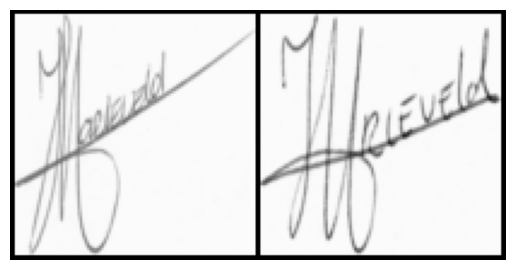

Predicted Eucledian Distance:- 1.0931742191314697
Actual Label:- Forged Pair Of Signature


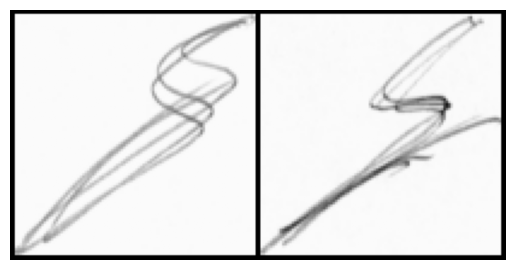

Predicted Eucledian Distance:- 0.939638078212738
Actual Label:- Forged Pair Of Signature


In [ ]:
count=0
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)

  if label==torch.FloatTensor([[0]]):
    label="Original Pair Of Signature"
  else:
    label="Forged Pair Of Signature"

  imshow(torchvision.utils.make_grid(concat))
  print("Predicted Eucledian Distance:-",eucledian_distance.item())
  print("Actual Label:-",label)
  count=count+1
  if count ==10:
     break